# Processing MT netCDF files using OPeNDAP 

### In this example, we will utilise OPeNDAP services to access and process raw MT time-series that are stored as netCDF files on NCI's THREDDS data server.

### Clear notebook memory

In [1]:
%reset -f

#%whos

In [2]:
### Un-comment to remove unwanted existing files

#rm *.mseed bx by ex ey fft.* c01.* time birrp.cfg c01_netcdf.edi survey.cfg C01.edi

### Import python modules

In [3]:
import os
import matplotlib.pyplot as plt
import subprocess
from multiprocessing import Process
import numpy as np
from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from datetime import datetime, timedelta
import pandas as pd
import glob
import datetime
from subprocess import call
%matplotlib inline

### Open up our netCDF file using the THREDDS OPeNDAP link

In [4]:
working_dir = '/g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf'
os.chdir(working_dir)
TS_path = 'http://dapds00.nci.org.au/thredds/dodsC/uc0/my80_dev/netCDF_test.nc'
TS = Dataset(TS_path)

### Uncomment line below if you want to use the local path.
#TS_path = '/g/data/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/netCDF_test.nc'


### Query what data is in our netCDF file

In [5]:
for item in TS.dimensions:
    print TS.dimensions[item].name, TS.dimensions[item].size

vars = TS.variables.keys()
for item in vars:
    print 'Variable: \t', item
    print 'Dimensions: \t', TS[item].dimensions
    print 'Shape:    \t', TS[item].shape, '\n'

bx 82800000
by 82800000
ex 82800000
ey 82800000
latitude 1
longitude 1
time 82800000
Variable: 	latitude
Dimensions: 	(u'latitude',)
Shape:    	(1,) 

Variable: 	ex
Dimensions: 	(u'ex',)
Shape:    	(82800000,) 

Variable: 	longitude
Dimensions: 	(u'longitude',)
Shape:    	(1,) 

Variable: 	ey
Dimensions: 	(u'ey',)
Shape:    	(82800000,) 

Variable: 	bx
Dimensions: 	(u'bx',)
Shape:    	(82800000,) 

Variable: 	by
Dimensions: 	(u'by',)
Shape:    	(82800000,) 

Variable: 	time
Dimensions: 	(u'time',)
Shape:    	(82800000,) 



### Extract some time-series data

In [6]:
### For this example, let's extract 20M data points for electric and magnetic time-series

start_point = 0
end_point = 20000000

ex = TS.variables['ex'][start_point:end_point]
ey = TS.variables['ey'][start_point:end_point]
bx = TS.variables['bx'][start_point:end_point]
by = TS.variables['by'][start_point:end_point]

time = TS.variables['time'][start_point:end_point]

lat = TS.variables['latitude']
lon = TS.variables['longitude']

### Plot some of the TS data

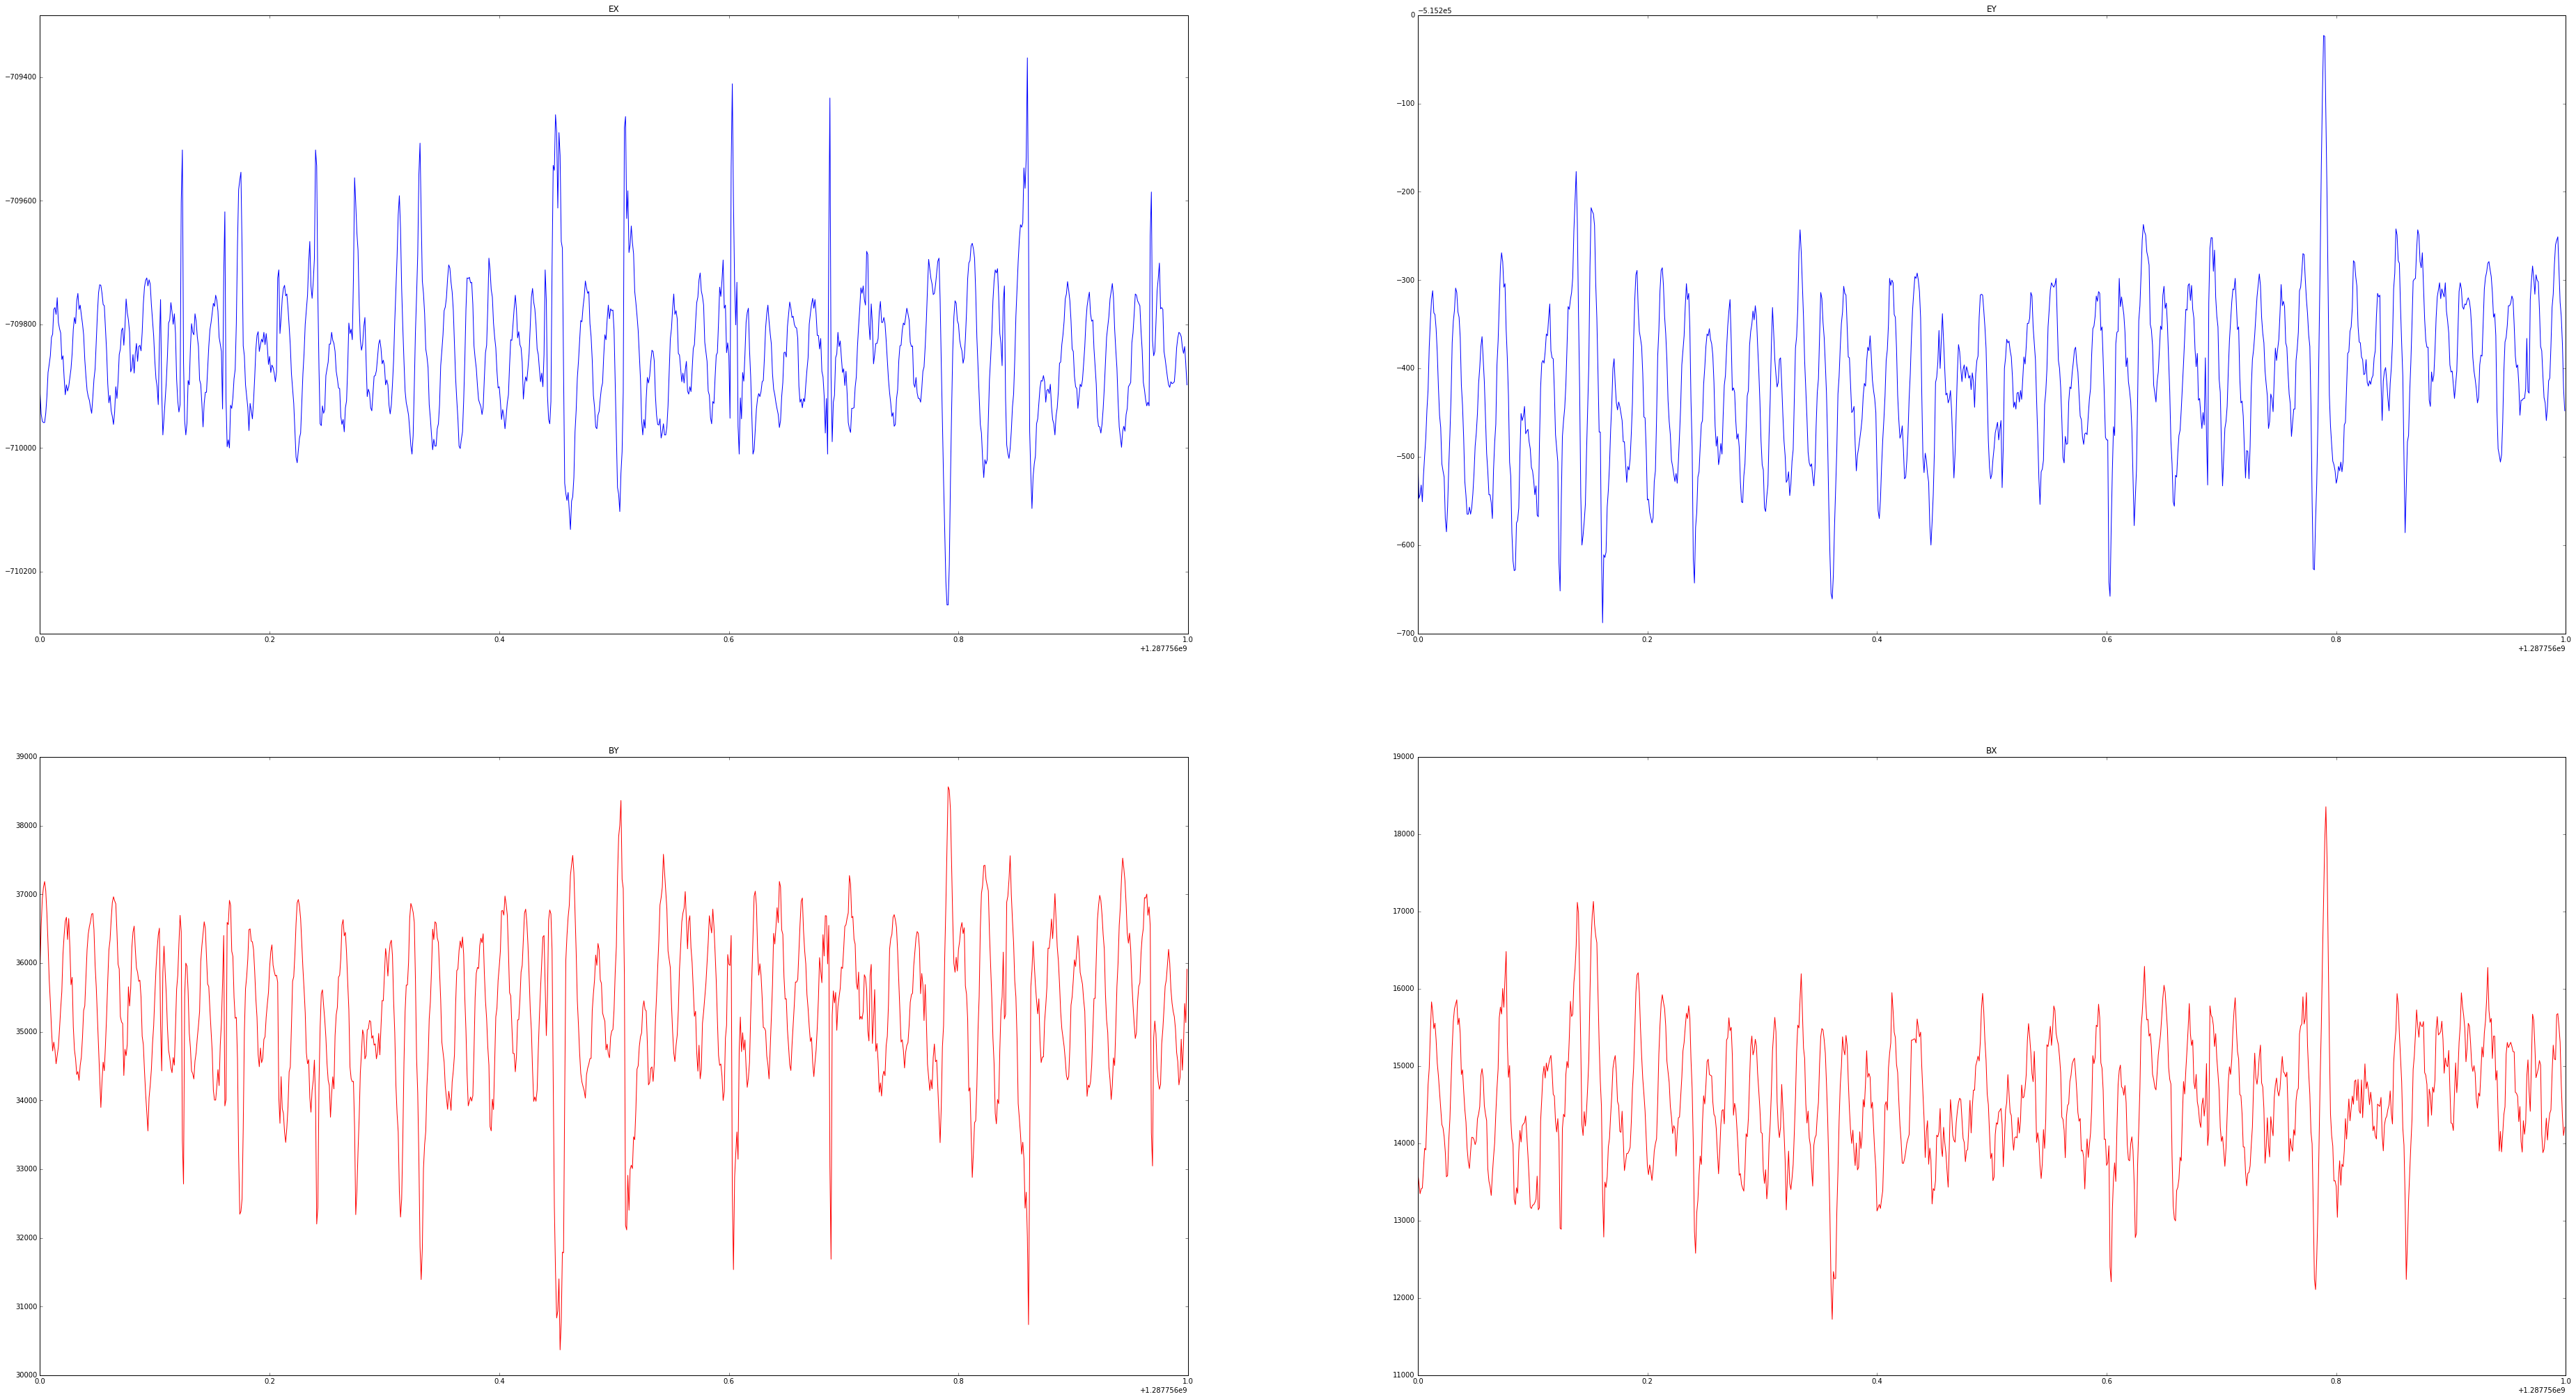

In [7]:
plt.rcParams['figure.figsize'] = [65, 35]

x = 0
y = 1000


f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(time[x:y], ex[x:y])
ax1.set_title('EX')
ax2.plot(time[x:y], ey[x:y])
ax2.set_title('EY')
ax3.plot(time[x:y], by[x:y], color='r')
ax3.set_title('BY')
ax4.plot(time[x:y], bx[x:y], color='r')
ax4.set_title('BX')

### Now let's write TS ascii files that are ready for BIRRP processing

In [8]:
%%time

def writets(name,ts):
    """
    write TS as ascii files
    """
    result = np.savetxt(name, ts, fmt="%i")
    proc = os.getpid()
    print('{0} savetxt by process id: {1}'.format(
        name, proc))
 
if __name__ == '__main__':
    names = ['ex','ey','bx','by','time'] 
    timeseries = [ex, ey, bx, by, time]
    procs = []
 
    for name, ts in zip(names,timeseries):
        proc = Process(target=writets, args=(name,ts,))
        procs.append(proc)
        proc.start()
 
    for proc in procs:
        proc.join()

time savetxt by process id: 27282
ey savetxt by process id: 27279
ex savetxt by process id: 27278
by savetxt by process id: 27281
bx savetxt by process id: 27280
CPU times: user 12 ms, sys: 38 ms, total: 50 ms
Wall time: 1min 23s


### A convienent tool for visualising time-series is [snuffler](https://pyrocko.org/v0.3/apps_snuffler_manual.html). In order to convert our TS to [miniSEED](https://ds.iris.edu/ds/nodes/dmc/data/formats/miniseed/) format, we must first add header information to our ascii files:

In [9]:
BX = [f for f in os.listdir(working_dir) if f.startswith('bx') and f.endswith('bx')]
BY = [f for f in os.listdir(working_dir) if f.startswith('by') and f.endswith('by')]
EX = [f for f in os.listdir(working_dir) if f.startswith('ex') and f.endswith('ex')]
EY = [f for f in os.listdir(working_dir) if f.startswith('ey') and f.endswith('ey')]
#TIME = [f for f in os.listdir(working_dir) if f.startswith('time')]

In [10]:

start_time = datetime.datetime.fromtimestamp(int(time[0])).strftime('%Y-%m-%d'+'T' +'%H:%M:%S'+'.0000')
station_BX = 'MagX_CP1L01_Capricorn_BX_QUAL'
station_BY = 'MagY_CP1L01_Capricorn_BY_QUAL'
station_EX = 'ElecX_CP1L01_Capricorn_EX_QUAL'
station_EY = 'ElecY_CP1L01_Capricorn_EY_QUAL'
samples = 20000000
sampling_rate_Hz = 1000

string_bx =  'TIMESERIES %s, %s samples, %s sps, %s, SLIST, INTEGER, Counts \n' % (station_BX, samples, sampling_rate_Hz, start_time)
string_by =  'TIMESERIES %s, %s samples, %s sps, %s, SLIST, INTEGER, Counts \n' % (station_BY, samples, sampling_rate_Hz, start_time)
string_ex =  'TIMESERIES %s, %s samples, %s sps, %s, SLIST, INTEGER, Counts \n' % (station_EX, samples, sampling_rate_Hz, start_time)
string_ey =  'TIMESERIES %s, %s samples, %s sps, %s, SLIST, INTEGER, Counts \n' % (station_EY, samples, sampling_rate_Hz, start_time)


In [11]:
string = [string_ex, string_ey, string_bx, string_by]

### Add header information to ASCII files for mseed conversion

In [12]:
%%time
from itertools import izip, count

def mseedheader(ascfiles,string):
        proc = os.getpid()
        print('{0} added header by process id: {1}'.format(ascfiles, proc))
        for i in ascfiles:
            with open(i,'r') as original:
                data = original.read()
                with open(i,'w') as modified:
                    modified.write(string + data)

 
if __name__ == '__main__':
    asciifiles = [EX, EY, BX, BY]
    string = [string_ex, string_ey, string_bx, string_by]
    procs = []
 
    for i,fs,st in izip(count(),asciifiles,string):
        proc = Process(target=mseedheader, args=(fs,st,))
        procs.append(proc)
        proc.start()
 
    for proc in procs:
        proc.join()

['ey'] added header by process id: 5124
['bx'] added header by process id: 5125
['ex'] added header by process id: 5123
['by'] added header by process id: 5130
CPU times: user 7 ms, sys: 42 ms, total: 49 ms
Wall time: 1.3 s


### We can convert our time series ASCII files to miniseed using the IRIS [ascii2mseed](https://seiscode.iris.washington.edu/projects/ascii2mseed) code:

In [13]:
%%time

def convert2mseed(files):
    for input_file in files:
        proc = os.getpid()
        print('create mseed {0} by process id: {1}'.format(input_file, proc))
        output_file = input_file + ".mseed"
        call(['ascii2mseed', input_file, "-o", output_file])
    
if __name__ == '__main__':
    types = [EX, EY, BX, BY] 
    procs = []
 
    for fs in types:
        proc = Process(target=convert2mseed, args=(fs,))
        procs.append(proc)
        proc.start()
 
    for proc in procs:
        proc.join()

create mseed ex by process id: 9352
create mseed ey by process id: 9353
create mseed bx by process id: 9359
create mseed by by process id: 9361
CPU times: user 6 ms, sys: 45 ms, total: 51 ms
Wall time: 5.52 s


### To convert our time-series files back to useable BIRRP inputs, we need to remove the header information we just created:

In [14]:
%%bash

for i in ex ey bx by;
do
    sed -i -e 1d "$i" &
done
wait 

### Let's check that BIRRP input file lengths are the same

In [15]:
%%bash

for i in bx by ex ey;
do
    wc "$i" &
done
wait

 20000000  20000000 119015069 bx
 20000000  20000000 120000399 by
 20000000  20000000 160000000 ey
 20000000  20000000 160000000 ex


### To view our miniseed time-series in snuffler, open up a VDI terminal in our working directory and run:

``` 
    $ module load snuffler
    $ snuffler *.mseed
    
```

### Now we have visualised and are happy with our time-series, let's extract the birrpstring given in our netCDF file:

In [16]:
birrpstring = TS.birrpstring

### Now we can run BIRRP using our extracted birrpstring:

In [17]:
from subprocess import Popen, PIPE

p = Popen('birrp-5.3.2', stdin=PIPE) #NOTE: no shell=True here
p.stdin.write(birrpstring)

## Converting BIRRP output to EDI file

### Let's extract and write the BIRRP config file from our netCDF file:

In [18]:
birrp_cfg = TS.birrp_cfg

In [19]:
# write the birrp.cfg file

with open('birrp.cfg','w') as text_file:
    text_file.write("%s" %birrp_cfg)

### Now we can extract and write our survey config file:

In [20]:
survey_cfg = TS.survey_cfg

In [21]:
# write the survey.cfg file

with open('survey.cfg','w') as text_file:
    text_file.write("%s" %survey_cfg)

### Let's try and write an EDI file using MTpy:

In [22]:
# directory where MTpy is installed
mtpy_directory = '/short/z00/nre900/MT/mtpy/'

os.chdir(mtpy_directory)

from mtpy.processing.birrp import convert2edi

os.chdir(working_dir)

In [23]:
# convert BIRRP outputs to EDI files

stationname = 'c01'
survey_configfile = 'survey.cfg'
in_dir = '.'
birrp_configfile = 'birrp.cfg'
convert2edi(stationname, in_dir, survey_configfile, birrp_configfile, out_dir = None)

'/g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/C01.edi'

### MTpy plotting from EDI

In [24]:
## import MTpy modules

os.chdir(mtpy_directory)

import mtpy.core.mt as mt

os.chdir(working_dir)

### Let's use the EDI provided from our netCDF file:

In [25]:
edi_fn = TS.EDI

In [26]:
with open('c01_netcdf.edi','w') as text_file:
    text_file.write("%s" %edi_fn)

In [27]:
edi = '/g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01_netcdf.edi'

In [28]:
mt_obj = mt.MT(edi)

 ...nulled all attributes of current MTedi.Edi instance.
reading in Edi file: /g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01_netcdf.edi
z
Could not read Tipper section: /g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01_netcdf.edi
Flipping arrays to be ordered from short period to long


mtpy/analysis/zinvariants.py:90: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


 ...nulled all attributes of current MTedi.Edi instance.
reading in Edi file: /g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01_netcdf.edi
z
Could not read Tipper section: /g/data3/my80/States_and_Territories/test/TS/example_TS_ascii_to_netcdf/c01_netcdf.edi
Flipping arrays to be ordered from short period to long


mtpy/core/z.py:1304: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
mtpy/core/z.py:1362: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
mtpy/imaging/mtplottools.py:392: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


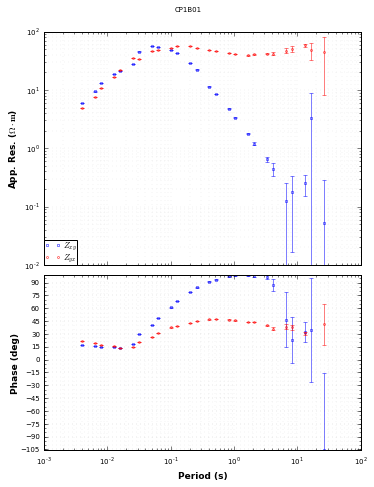

In [29]:
mt_plot = mt_obj.plot_mt_response()

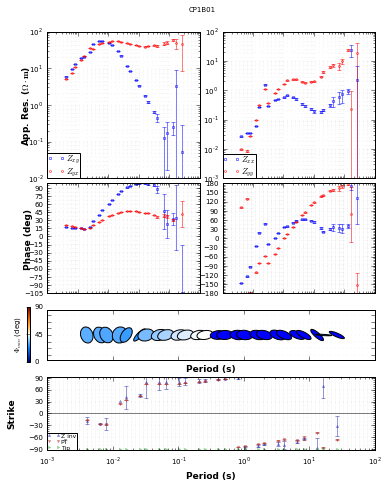

In [30]:
mt_plot.plot_pt = 'y'
mt_plot.plot_strike = 'ytip'
mt_plot.plot_num = 2
mt_plot.redraw_plot()